<h1> TP3 IQ01, partie 1 </h1>

L'algorithme de Deutsch-Jozsa a été le premier exemple d'un algorithme quantique dont les performances sont supérieures à celles du meilleur algorithme classique. Il a montré qu'il peut être avantageux d'utiliser un ordinateur quantique comme outil de calcul pour un problème spécifique.
<h3> Rappels sur les oracles </h3>

Oracle permet d'implémenter en quantique une fonction black box à laquelle on donne un input x et reçoit un output y.
Ceci permet de se concentrer sur les technhiques quantiques pour analyser la fonction plutôt que la fonction en elle même.

Un boolean oracle : 
$U_f \left|x , \bar 0 \right\rangle = \left|x, f(x)\right\rangle.$

Ici,
$\left|x , \bar 0 \right\rangle = \left|x \right\rangle \otimes \left|\bar 0 \right\rangle$ représente un état à plusieurs qubit composé de 2 registres. Le premier est dans l'état $\left|x\right\rangle$ où x est une représentation binaire de l'input de notre fonction, le nb de qubits dans ce registre est le nb de bits nécéssaires pour représenter l'input.

Le deuxième registre permet d'encoder l'output. L'état de ce registre après avoir appliqué $U_f$ sera une représentation binaire de l'output $\left|f(x)\right\rangle$. Ici, tous les qubits sont initialisés à 0.


Il existe aussi des phase oracle : $P_f \left|x \right\rangle = (-1)^{f(x)} \left|x \right\rangle$ avec f(x) 0 ou 1, ce qu'on va utiliser ici.

<h3>Etapes de l'algo</h3>

1. Préparation des registre quantique (1er : n-qubit registre initiliasé à |0>, 2ème 1-qubit registre initialisé à |1>.
2. Application porte Hadamard à tout les qubit n+1qubit
3. Application de l'oracle quantique
4. Ici, le 2ème registre peut être ignoré. On applique un Hadamard sur chaque qubit du premier registre.
5. Mesure du premier registre.

<h3> Pourquoi ça marche ? </h3>
<h4> Oracle constant </h4>

Quand l'oracle est constant, pas d'effet sur les qubit en entrée, les états quantiques avant et après l'oracle sont les même. Comme le Hadamard est son propre inverse, on inverse à l'étape 4 l'étape 2 pour obtenir les étatsi nitiaux |00...0> dans le premier registre.

$H^{\otimes n}\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\quad \xrightarrow{\text{after } U_f} \quad
H^{\otimes n}\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
= 
\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}$

<h4> Oracle équilibré </h4>
Après l'étape 2, notre registre d'entrée est une égale superposition des états dans la base de calcul. Quand l'oracle est équilibré, ajout d'une phase négative à exactement la moitié des états.

$U_f \tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} -1 \\ 1 \\ -1 \\ \vdots \\ 1 \end{bmatrix}$

L'état quantique après l'oracle est orthogonal à l'état quantique avant. Donc dans l'étape 4, quand on applique le H gate, on obtient un état quantique orthogonal à |00...0> donc on ne devrait jamais mesurer l'état consititué de tous les 0.

<h3> Algorithme et code </h3>

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

<h4> Oracle constant </h4>

Dans le cas d'un oracle constant, l'input n'a pas d'effet sur l'output donc on met le qubit de output soir à 0 soit à 1, peu importe.

In [3]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

q_0: 
     
q_1: 
     
q_2: 
     
q_3:

<h4> Oracle équilibré </h4>

On le crée en utilisant des CNOT avec pour contrôle chaque qubit d'entrée et pour target chaque qubit de sortie. Nous pouvons varier les états d'entrée qui donnent 0 ou 1 en enveloppant certaines des commandes dans des X-gates.

In [10]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()



┌───┐ ░                 ░ ┌───┐
q_0: ┤ X ├─░───■─────────────░─┤ X ├
     └───┘ ░   │             ░ └───┘
q_1: ──────░───┼────■────────░──────
     ┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ X ├─░───┼────┼────■───░─┤ X ├
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░──────
           ░ └───┘└───┘└───┘ ░

On peut maintenant faire l'algo final : 

On commence par initiliser tous les qubits en input à |+> et les qubit en output à |->.

In [11]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘
c: 3/══════════

On applique l'oracle : 

In [12]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle
dj_circuit.draw()

C:\Users\axela\AppData\Local\Temp\ipykernel_23260\525878989.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


┌───┐┌───┐ ░                 ░ ┌───┐
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├
     ├───┤└───┘ ░   │             ░ └───┘
q_1: ┤ H ├──────░───┼────■────────░──────
     ├───┤┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘└───┘ ░      
c: 3/════════════════════════════════════

On applique les portes Hadamard sur les n qubit d'entrée et on mesure le registre d'entrée.

In [13]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()


C:\Users\axela\AppData\Local\Temp\ipykernel_23260\2412001177.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


┌───┐┌───┐ ░                 ░ ┌───┐┌───┐ ░ ┌─┐      
q_0: ┤ H ├┤ X ├─░───■─────────────░─┤ X ├┤ H ├─░─┤M├──────
     ├───┤└───┘ ░   │             ░ ├───┤└───┘ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├──────░──╫─┤M├───
     ├───┤┌───┐ ░   │    │        ░ ├───┤┌───┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├─░───┼────┼────■───░─┤ X ├┤ H ├─░──╫──╫─┤M├
     ├───┤├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘└───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░────────────░──╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░            ░  ║  ║  ║ 
c: 3/═════════════════════════════════════════════╩══╩══╩═
                                                  0  1  2

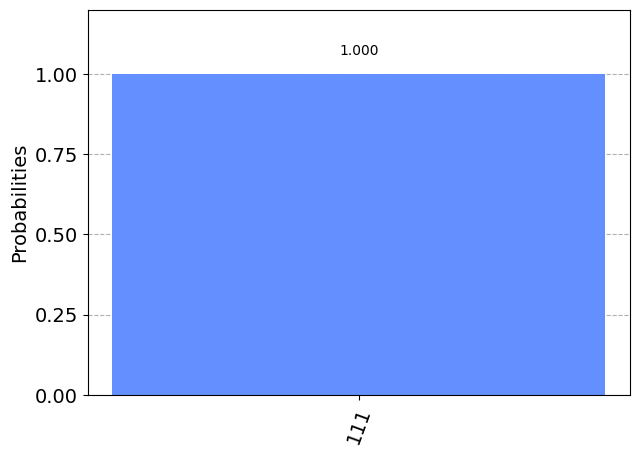

In [14]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


On a utilisé balanced_oracle, on a bien une chance nulle de mesurer 000 donc la fonction est bien équilibrée.

On peut réaliser une fonction généraliser pour faire des tests !
On crée d'abord une fonction qui crée des oracles deutsch-jozsa.

In [19]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate


On peut ensuite créer une fonction qui prend cet oracle et lui applique l'algo.

In [20]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit


On peut ensuite faire des tests : 

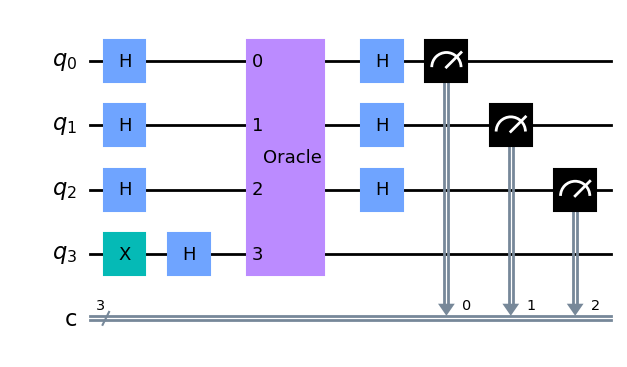

In [26]:
n = 3
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw('mpl')


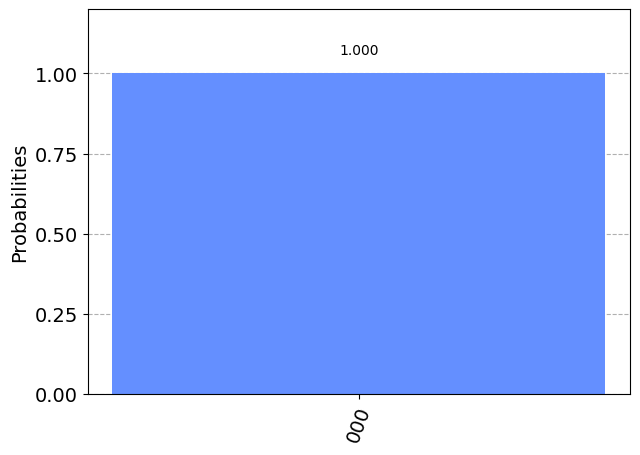

In [27]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(transpiled_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)


<h3> Résumé, notes </h3>


Ainsi, on a voulait déterminer si la fonction était équilibrée ou constante avec seulement 1 appel. On a défini l'oracle dans ces deux cas.

Pour le cas constant, on choisit aléatoirement si l'oracle renvoie uniquement des 0 ou uniquement des 1. Si l'oracle renvoie uniquement des 0, on ne fait rien car q3 est initialisé à l'état |0>. Si l'oracle renvoie uniquement des 1, on applique une porte X sur q3 pour qu'il soit dans l'état |1>.


Pour le cas équilibré, on met 3 CNOT sur q0, q1, q2 tandis que q3 est la sortie. Ces 3 CNOT permettent l'équilibrage (moitié 1, moitié 1).
On peut varier les fonctions équilibrées en modifiant les input des qubits q0, q1 et q2. Dans notre code, on se sert d'une chaine de caractère qui, quand elle est modifiée, permet d'obtenir une fonction différente mais toujours équilibrée. On place ensuite des portes X sur les qubits où on a fait une porte X pour inverser la manipulation.


Une fois notre oracle terminé, on peut s'occuper de l'algorithme. On commence par appliquer une porte H sur les 3 qubits en input. Puis, on applique une porte X et une porte H sur le qubit d'output. On applique ensuite l'oracle (soit balanced soit constant). On rapplique les porte H sur les 3 qubits en input et enfin, on les mesure.


Le résultat des mesures nous donne ainsi notre réponse et ce en 1 seul appel de l'oracle : quand l'oracle est constante, on mesure |000> et quand l'oracle est équilibré, on mesure |111>. (ici n = 3).


La généralisation à n qubits suit le même raisonnement.


<h1> TP3 IQ01, partie 2 </h1>

L'algorithme de Simon, comme celui de Deutsch-Josza, permet de montrer l'efficacité du quantique par rapport à un système classique.
Le problème de Simon constiste en une fonction black box qui peut être de 2 types : 

one-to-one : f(x) = x

two-to-one : f(x1) = f(x2) -> f(1) = 1, f(2) =2 , f(3) = 1, f(4) = 2 (notation simplifiée dans l'énoncé).

<h3> Analyse </h3>

On rensigne au départ la chaîne de bits b (de longueur n) puis on crée un registre quantique de $2^n$ qubits et un registre classique de n bits. Ensuite, on appliqui
e des portes Hadamard sur les n premiers qubits du registre quantique pour réaliser la superposition.
On applique ensuite l'oracle (que l'on a pas développé) qui prend en compte la chaine b sur les $2^n$ qubits.
On réapplique les portes hadamard sur les n premiers qubits du registre quantique et on mesure seulement ces qubits.

Ensuite, quand b est une chaine de plusieurs 0 (pour n =3, 000), on obtient $2^n$ mesures. Donc, pour chaque entrée, une seule solution est mesurée. Cette chaine b correspond donc au premier cas (une sortie unique pour chaque entrée).

Dans le cas où b n'est pas une suite de plusieurs 0, le nombre de sorties/output est de $2^{n-1}$ ou $2^{n}/2$. Cela correspond au deuxième cas où une sortie unique correspond à 2 entrées différentes.


La fonction bdotz permet la vérification. On a une sortie avec les mesures sur les n premiers qubits dans le cas où :

$(-1)^{x \cdot z} = (-1)^{y \cdot z}$

$x \cdot z = y \cdot z \\
     x \cdot z = \left( x \oplus b \right) \cdot z \\
     x \cdot z = x \cdot z \oplus b \cdot z \\
     b \cdot z = 0 \text{ (mod 2)}$
     
A partir de chaque output z, on vérifie cette égalité et on obtient finalement le système d'équations à partir duquel b peut être déterminé.


<h3> Algorithme et exemple </h3>

Implémentation avec 3 qubits et b = 110. On peut modifier la valeur de b pour effectuer différents tests.

In [1]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

On ne se préoccupe pas le l'output du 2ème registre, on ne va mesurer que le premier registre.

In [14]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()


C:\Users\axela\AppData\Local\Temp\ipykernel_13584\3044569139.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  simon_circuit += simon_oracle(b)


┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

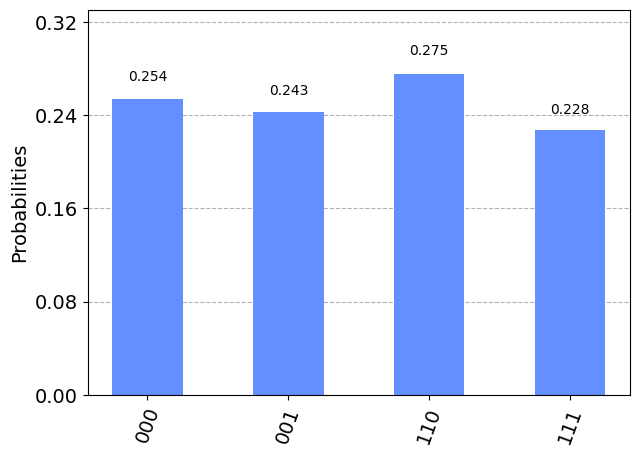

In [16]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


On obtient 4 sorties.
On vérifie que les résultats satisfont b.z = 0 (mod 2)

In [17]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )


110.000 = 0 (mod 2)
110.110 = 0 (mod 2)
110.111 = 0 (mod 2)
110.001 = 0 (mod 2)


En utilisant les résultats, on peut retrouver la valeur de b = 110 en résolvant cet ensemble d'équations. Par exemple, si notre première mesure est 001, on a que : 

$\require{cancel}
\begin{aligned}
b \cdot 001 &= 0 \\
(b_2 \cdot 0) + (b_1 \cdot 0) + (b_0 \cdot 1) & = 0 \\
(\cancel{b_2 \cdot 0}) + (\cancel{b_1 \cdot 0}) + (b_0 \cdot 1) & = 0 \\
b_0 & = 0\\
\end{aligned}$

Si ensuite, on mesure 111, on a :

$\require{cancel}
\begin{aligned}
b \cdot 111 &= 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) + (\cancel{0 \cdot 1}) & = 0 \\
(b_2 \cdot 1) + (b_1 \cdot 1) & = 0 \\
\end{aligned}$

Ce qui nous donne soit

$b_2 = b_1 = 0, \quad b = 000$

soit,

$b_2 = b_1 = 1, \quad b = 110$

Et donc b = 110 est la solution non-triviale de nos équations simultanées. On le fait en général par élimination gaussienne.